# U1T5 - Final Assignment - Dock Stations Placement

## Overview

In this notebook we'll attempt to find in the neighborhood of UFRN's central campus suitable places to install dock stations for bike sharing services in order to increase mobility in and out of the campus. For that we'll use OSMnx library to acquire map data for the surroundings of the university and observe centrality measurements as well as other metrics. The goal is to weigh the pros and cons of each approach and settle on a final layout.

## Browse

* [Data](#data)
* [Centrality Measurements](#centrality-measurements)
* [Degree Distribution](#degree-distribution)
* [Core](#core)
* [Key Findings](#key-findings)
* [Pros and Cons](#pros-and-cons)
* [Conclusion](#conclusion)

## Data

For the analyses performed in this notebook we'll consider only the neighborhoods that are in direct contact with the UFRN Campus, i.e. Lagoa Nova, Candelária and Capim Macio. For some functions that can't be performed with MultiGraphs, we'll use a simplified version of the map.

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
S = ox.graph_from_place(['Candelária, Natal, Brazil', 'Lagoa Nova, Natal, Brazil', 'Capim Macio, Natal, Brazil'], network_type='bike')
G = ox.convert.to_digraph(S)
plt.style.use('dark_background')

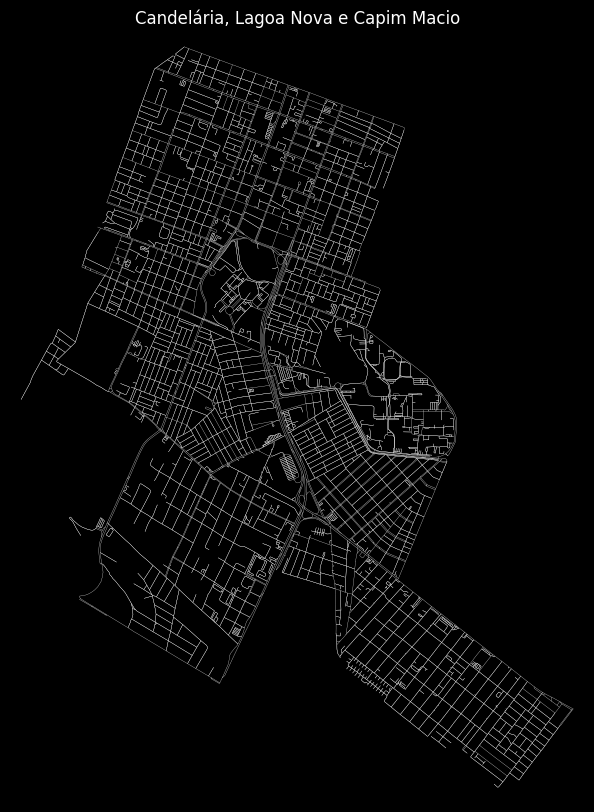

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Candelária, Lagoa Nova e Capim Macio')
ox.plot_graph(S, ax=ax, node_size=0, edge_color='w', edge_linewidth=0.2)

plt.show()

## Centrality Measurements

With our eyes towards only the closest neighborhoods of the campus, we'll calculate the centrality measurements in order to better see the local arrangement of roads and their importance for the mobility of residents.

Calculate and visualize the centrality measurements and integrating them to the graph as attributes

In [4]:
S_bc = nx.betweenness_centrality(S, weight="length")
S_cc = nx.closeness_centrality(S, distance="length")
S_dc = nx.degree_centrality(S)
S_ec = nx.eigenvector_centrality(G, tol= 1.0e-3)

nx.set_node_attributes(S, S_bc, "bc")
nx.set_node_attributes(S, S_cc, "cc")
nx.set_node_attributes(S, S_dc, "dc")
nx.set_node_attributes(S, S_ec, "ec")

In [5]:
# Create a dataframe with the centrality measures for visualization purposes
df = pd.DataFrame(S_bc.items(), columns=["Node","Betweenness"])
df["Closeness"] = S_cc.values()
df["Degree"] = S_dc.values()
df["Eigenvector"] = S_ec.values()

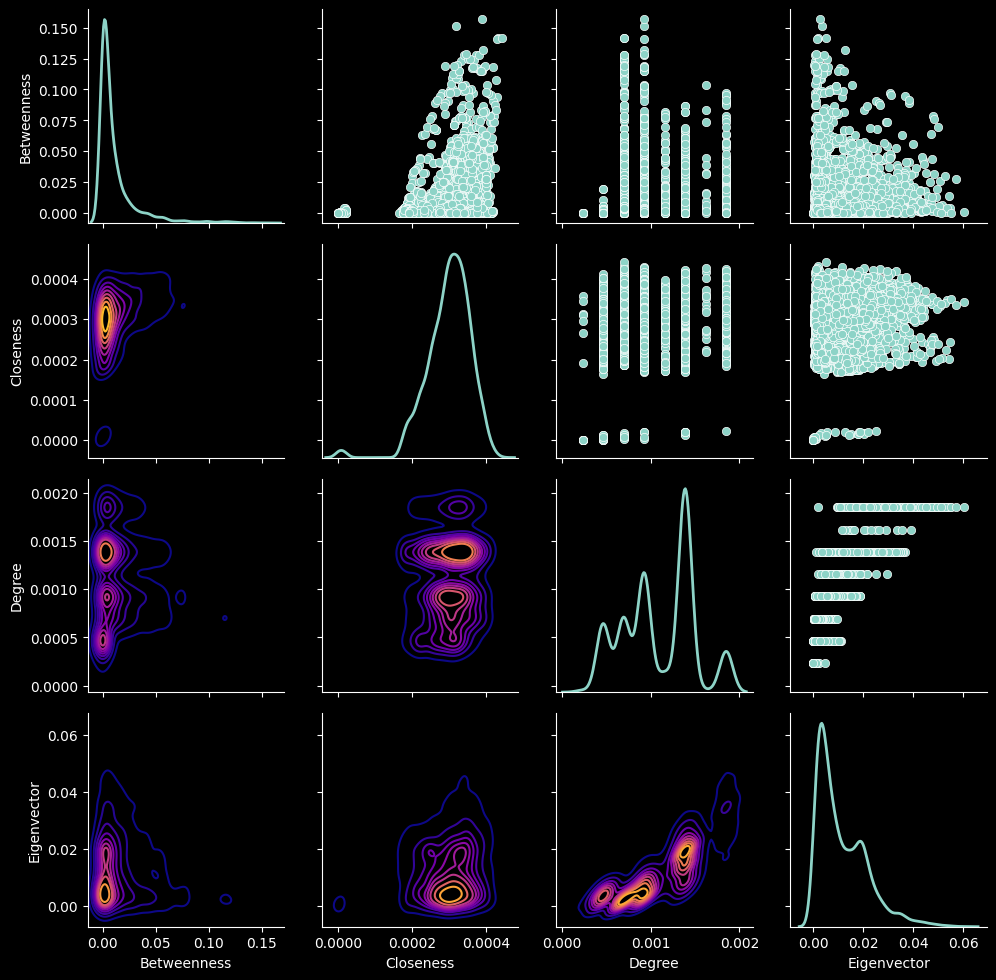

In [6]:
fig = sns.PairGrid(data=df[['Betweenness','Closeness', 'Degree', 'Eigenvector']], diag_sharey=False)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap='plasma')
fig.map_diag(sns.kdeplot, lw=2, legend=False)

plt.show()

From the figure above we can see that:
* Eigenvector centrality and degree centrality are positively correlated;
* Closeness and betweenness relationship highlights the fact the structural axis is somewhat centered in the map;
* Degree doesn't seem to correlate strongly with neither closeness nor betweenness.

To have a more spatial grip on those metrics, we'll compare the four in the actual map and see what can we extract from that.

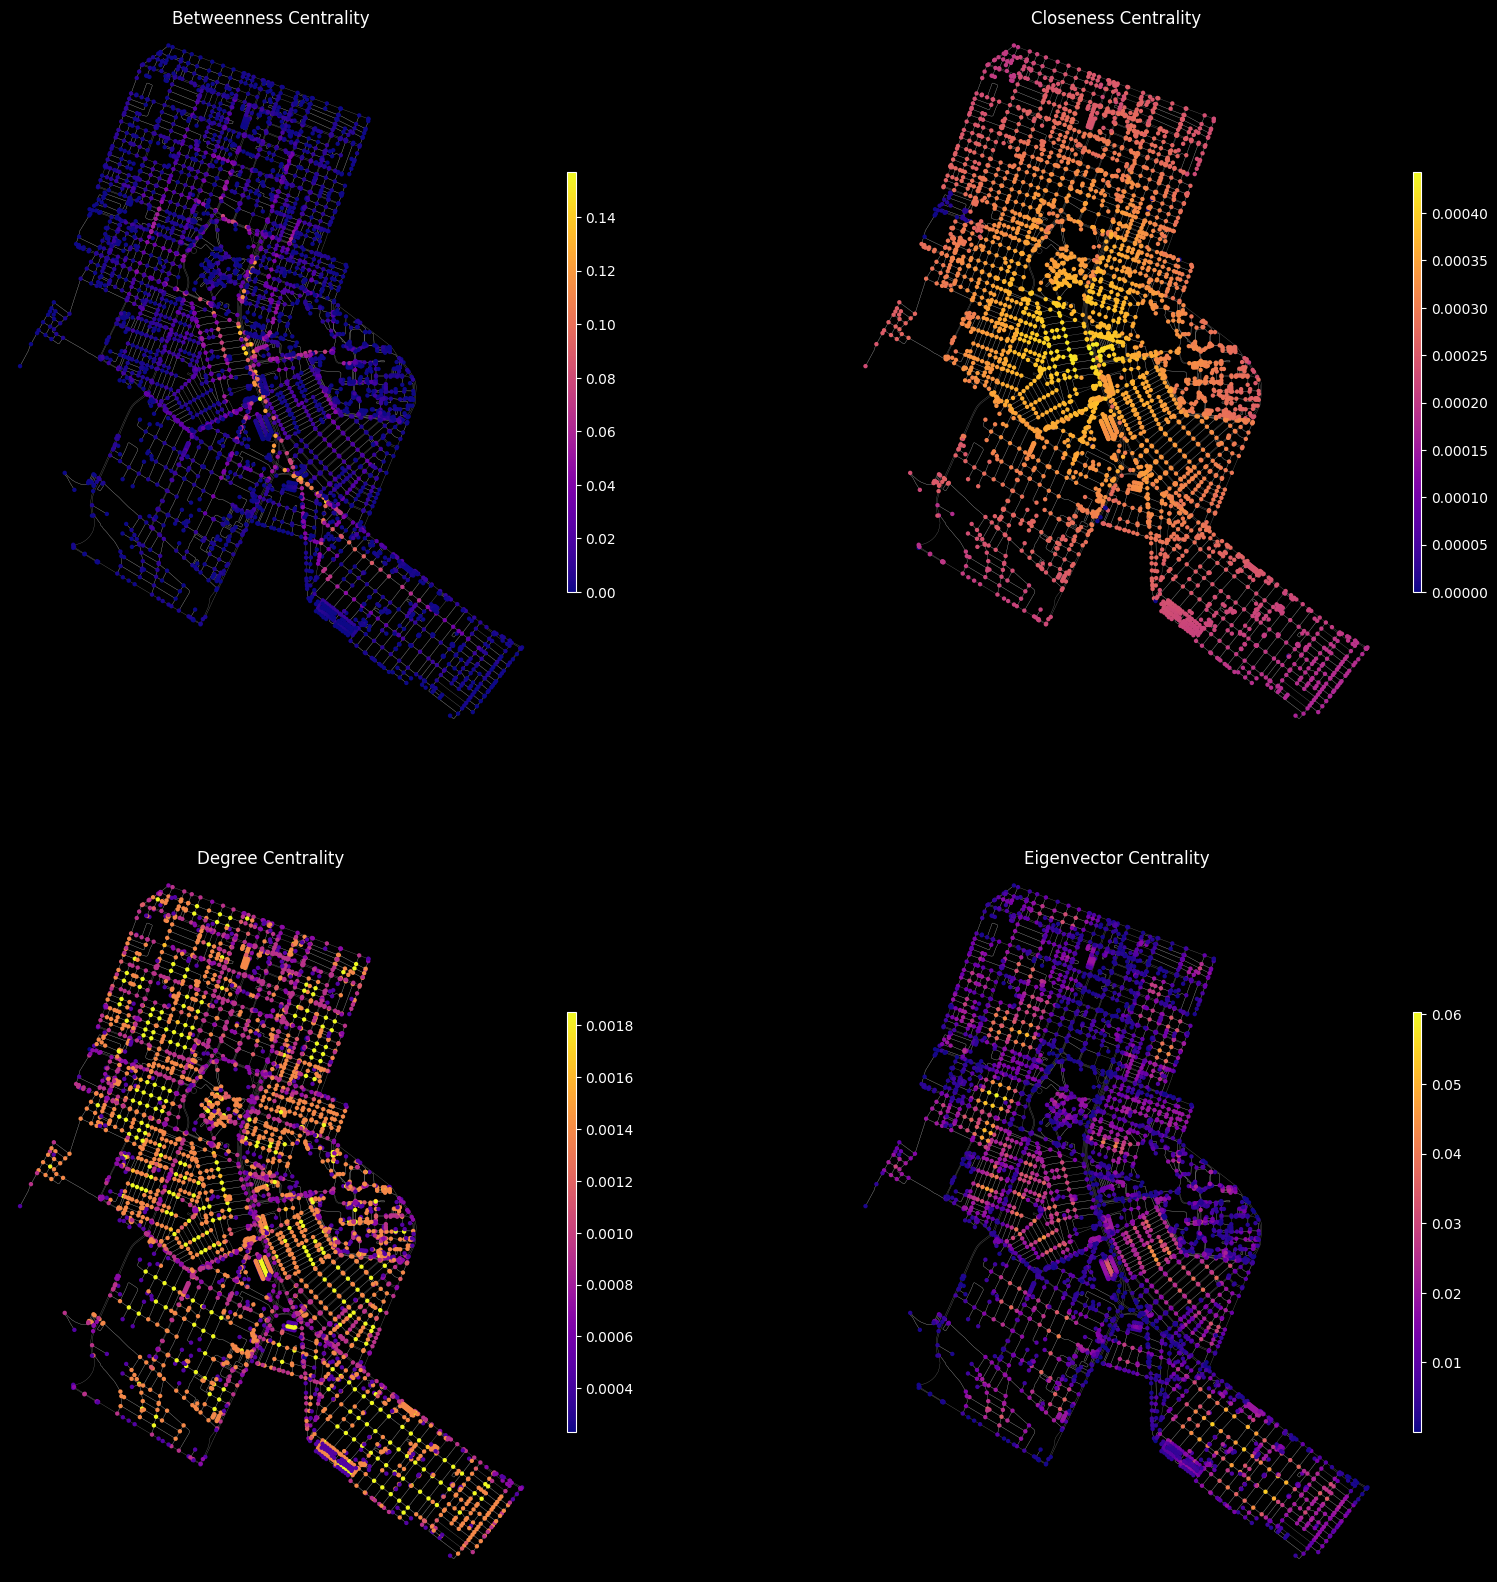

In [7]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20, 20), nrows=2, ncols=2)

metrics = [[("bc", "Betweenness Centrality"), ("cc","Closeness Centrality")],
           [("dc", "Degree Centrality"), ("ec", "Eigenvector Centrality")]]

for i, row in enumerate(metrics):
    for j, metric in enumerate(row):
        nc = ox.plot.get_node_colors_by_attr(S, metric[0], cmap="plasma")
        ax[i][j].set_title(metric[1])

        sm = plt.cm.ScalarMappable(cmap="plasma", norm=plt.Normalize(vmin=min(nx.get_node_attributes(S, metric[0]).values()), vmax=max(nx.get_node_attributes(S, metric[0]).values())))
        sm.set_array([])
        fig.colorbar(sm, ax=ax[i][j], shrink=0.6, aspect=50, location='right')
        ox.plot_graph(
            S,
            ax=ax[i][j],
            show=False,
            node_color=nc,
            node_size=10,
            edge_linewidth=0.2,
            edge_color="tab:gray",
        )

plt.show()

As we can see in the figure above, we can kind of pair up closeness with betweenness and eigenvector with degree. For our analysis, the latter pair seems a bit all over the place for it to shine some light on our task.

The closeness centrality is not a very good metric to analyze on its own for our purpose because even though we don't consider the public transportation network, we know the bicycles sharing systems act as a last mile component and therefore should be placed on areas close to a bus stop or something like that. However, it could be useful if we apply it in isolated neighborhoods to find a central location to install dock stations.

In [8]:
Candelaria = ox.graph_from_place('Candelária, Natal, Brazil', network_type='bike')
Capim_macio = ox.graph_from_place('Capim macio, Natal, Brazil', network_type='bike')
Lagoa_nova = ox.graph_from_place('Lagoa Nova, Natal, Brazil', network_type='bike')

top_nodes_by_neighborhood = []
cc = nx.closeness_centrality(Candelaria, distance="length")
nx.set_node_attributes(S, cc, "cc")
top_nodes_by_neighborhood += sorted(cc, key=cc.get, reverse=True)[:5]

cc = nx.closeness_centrality(Capim_macio, distance="length")
nx.set_node_attributes(S, cc, "cc")
top_nodes_by_neighborhood += sorted(cc, key=cc.get, reverse=True)[:5]

cc = nx.closeness_centrality(Lagoa_nova, distance="length")
nx.set_node_attributes(S, cc, "cc")
top_nodes_by_neighborhood += sorted(cc, key=cc.get, reverse=True)[:5]


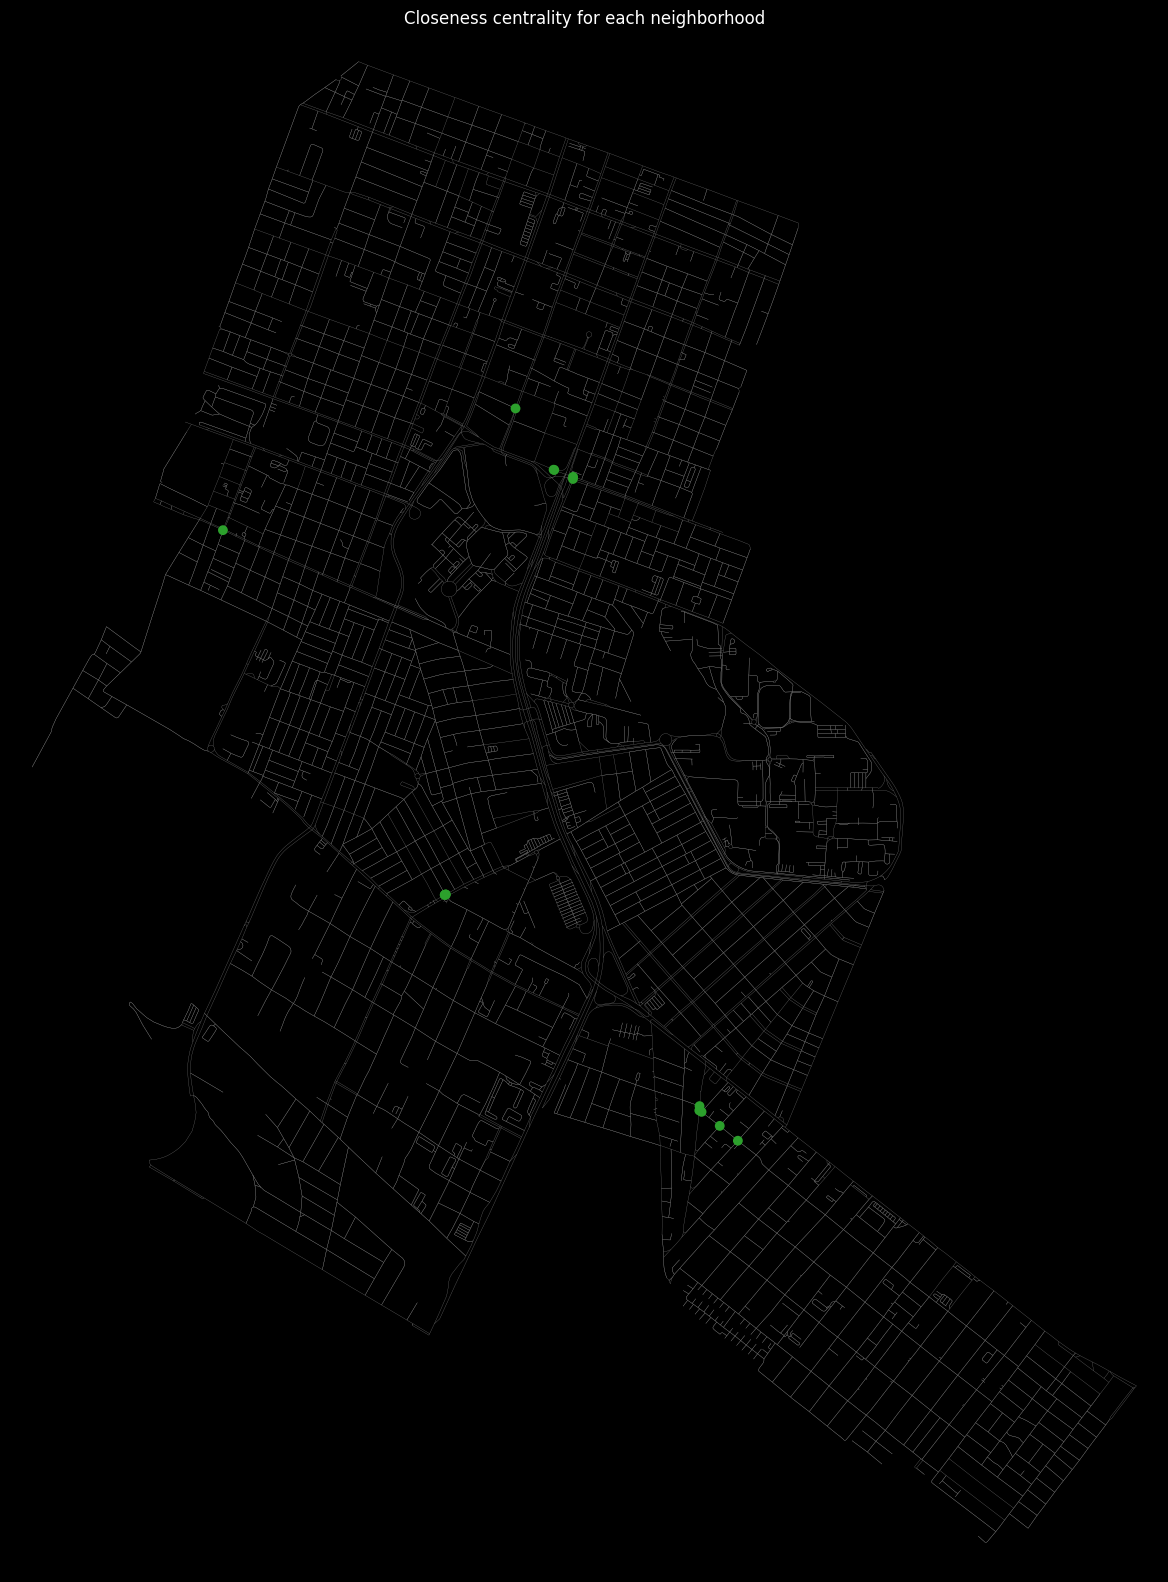

In [9]:
node_size = [50 if node in top_nodes_by_neighborhood else 0 for node in S.nodes]

fig, ax = plt.subplots(figsize=(25, 20), facecolor="k")
ax.set_title("Closeness centrality for each neighborhood", {"color": 'w'})
ax.set_facecolor('k')
ox.plot_graph(
    S,
    ax=ax,
    node_color='tab:green',
    node_size=node_size,
    edge_linewidth=0.2,
    edge_color="tab:gray",
)
plt.show()

The graph above could be useful as it show the most "central" nodes for each neighborhood, making the highlighted areas good candidates for dock stations if we could only install so few of them through the area.

## Degree Distribution

The multivariable analysis on the previous section kind of hinted that degree isn't a very good metric for our study because the number of connections a node make is constrained by the city's organization and grid system.

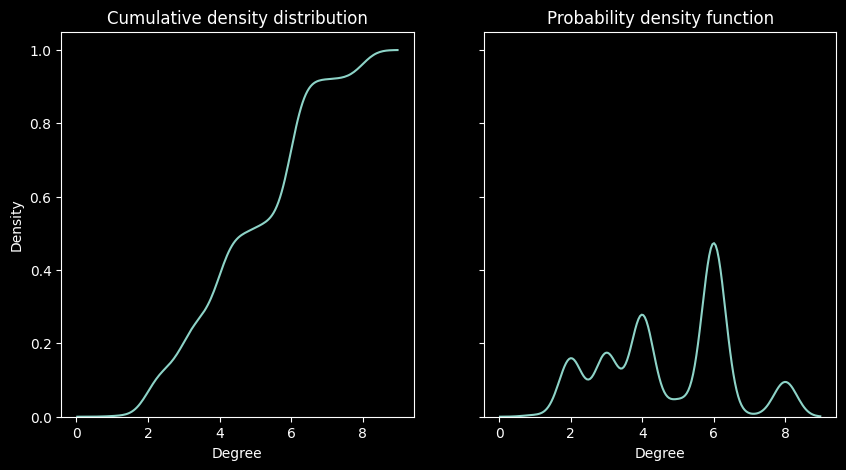

In [10]:
degrees = sorted([d for n, d in S.degree()])
plt.style.use('dark_background')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
ax[0].set_title("Cumulative density distribution")
ax[1].set_title("Probability density function")
ax[0].set_xlabel("Degree")
ax[1].set_xlabel("Degree")

sns.kdeplot(degrees, ax=ax[0], cumulative=True)
sns.kdeplot(degrees, ax=ax[1])

plt.show()

However, the previous visualization is still useful to note that as what we'd expect from a orthogonal grid system, odd number of connections are rarely seem in comparison to even ones.

## Core

We'll strip down the map to its innermost core and shell as to find the areas that keep the more densely connected nodes and take a look at them.

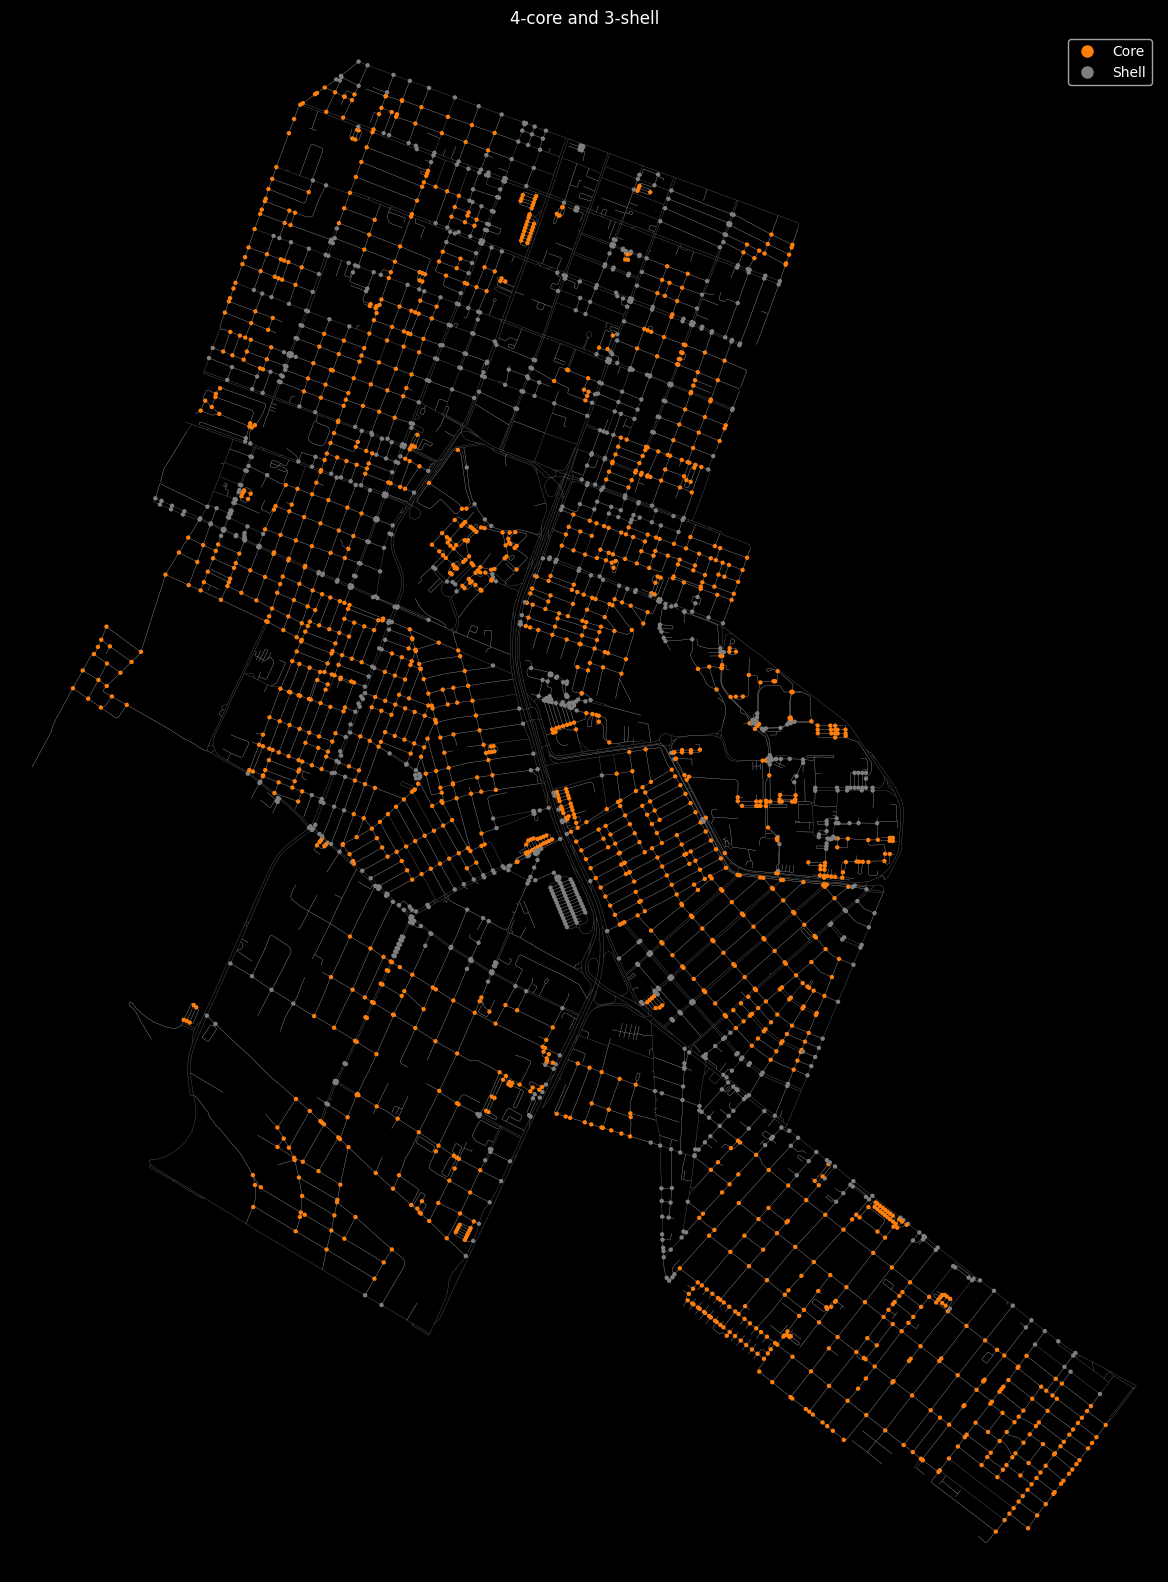

In [11]:
from matplotlib.lines import Line2D

G.remove_edges_from(nx.selfloop_edges(G))
n_cores = sorted(list(set([v for k, v in nx.core_number(G).items()])))

G_shell = nx.k_shell(G, k=n_cores[-2])
G_core = nx.k_core(G, k=n_cores[-1])


fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title(f"{n_cores[-1]}-core and {n_cores[-2]}-shell", {"color": 'w'})
nc = ["tab:orange" if node in G_core.nodes else "tab:gray" if node in G_shell.nodes else "none" for node in G.nodes]


legend_elements = [Line2D([0], [0], marker='o', color='k', label='Core', markersize=10, markerfacecolor='tab:orange'),
                   Line2D([0], [0], marker='o', color='k', label='Shell', markersize=10, markerfacecolor='tab:gray')]

ax.legend(handles=legend_elements, loc='upper right')


ox.plot_graph(
    S, 
    ax=ax,
    node_color=nc, 
    node_size=10, 
    edge_linewidth=0.2, 
    edge_color='gray'
)
plt.show()

The decomposition of the network into its innermost core has some correspondence with the 'residential' area of the city, i.e., the small streets network that give access to most of the houses and residential buildings. The 3-shell on the other hand has a loose link with big avenues that stretch for long distances. This might be due to the grid system and how those small streets often are two-way streets and tend to be intersections.

Anyways, the segmented core could be useful to study the placement of dock stations because it offers the opportunity to spread the stations more evenly than by neighborhood as we mentioned previously.

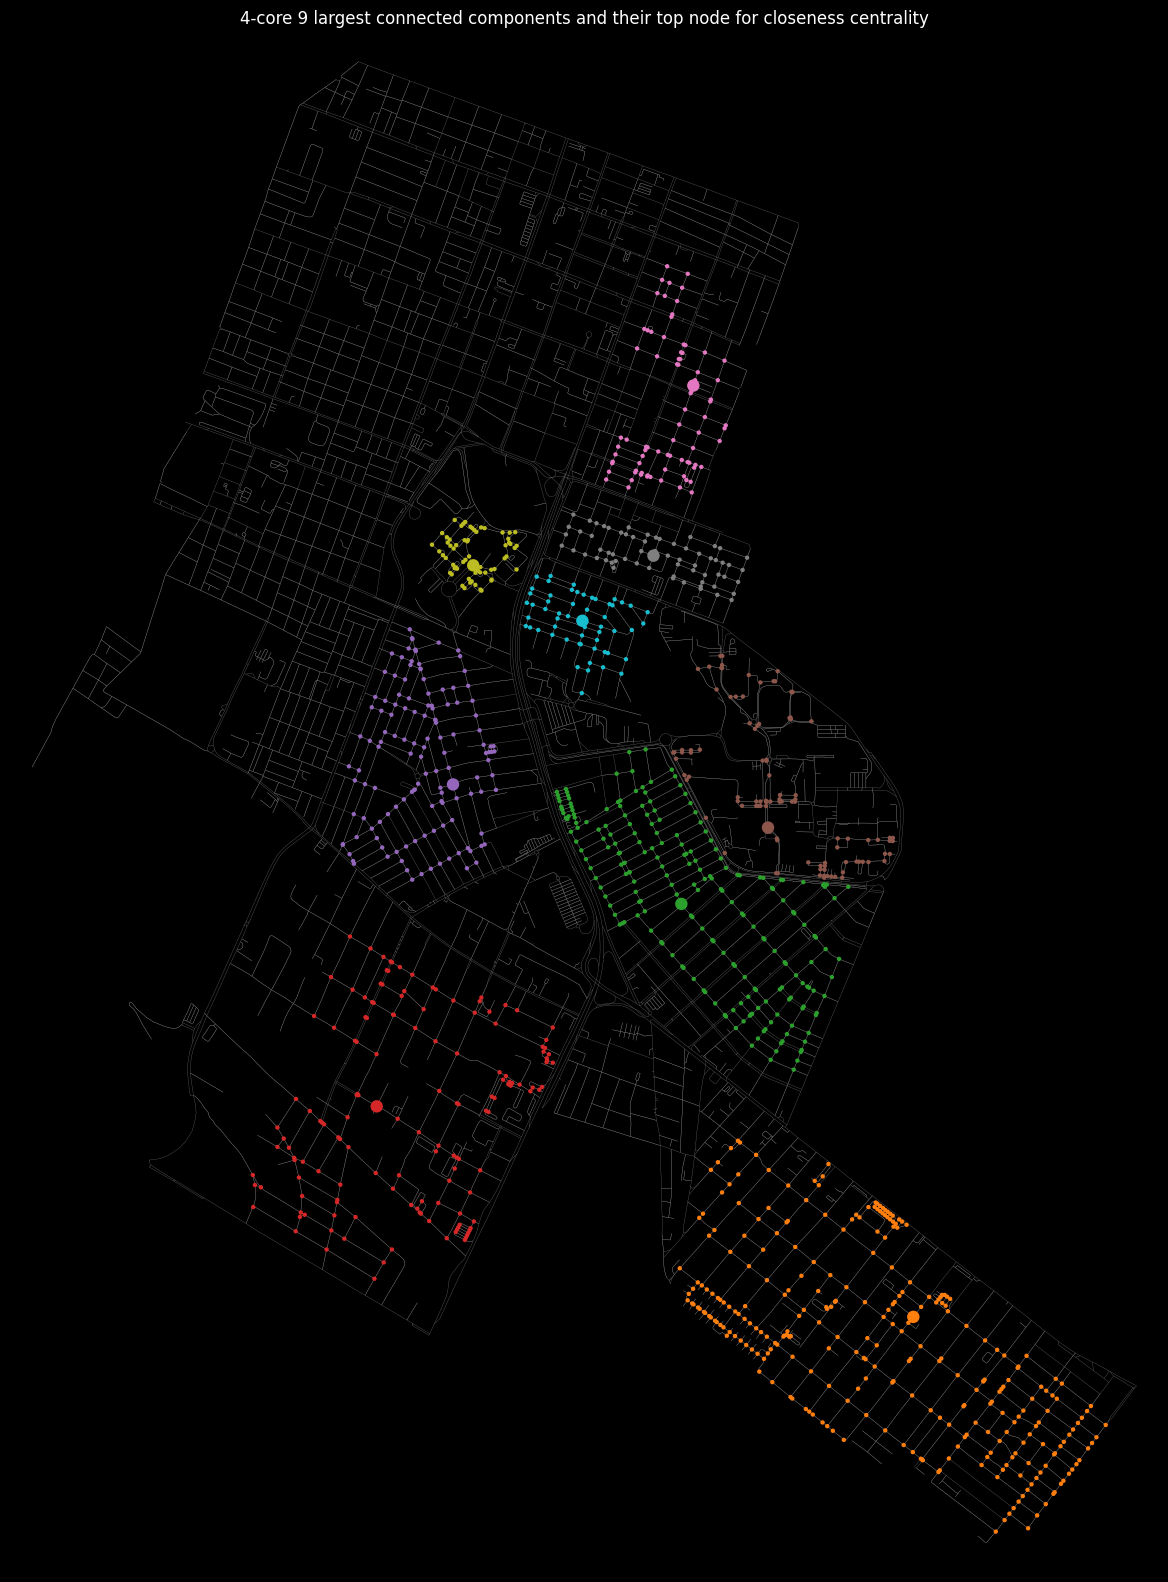

In [15]:
A = nx.number_connected_components(G_core.to_undirected())
colors = sns.color_palette("tab10", A)
node_colors = {}
center_nodes = []
for i, component in enumerate(sorted(nx.connected_components(G_core.to_undirected()), key=len, reverse=True)[:10]):
    # Assign a unique color to each connected 
    try:
        center_nodes.append(nx.center(G_core.subgraph(component), weight="length")[0])
        for node in component:
            node_colors[node] = colors[i]
    except:
        pass
    

# Plot the graph showing the connected components in different colors
figs, ax = plt.subplots(figsize=(20, 20))
ax.set_title(f"{n_cores[-1]}-core {len(center_nodes)} largest connected components and their top node for closeness centrality")
ox.plot_graph(
    S, 
    ax=ax,
    node_size=[80 if node in center_nodes else 10 for node in S.nodes], 
    node_color=[node_colors.get(node, "none") for node in S.nodes], 
    edge_linewidth=0.2, 
    edge_color="tab:gray"
    )
plt.show()

## Key Findings

* **Centrality Measurements**:
    * Eigenvector centrality and degree centrality are positively correlated.
    * Closeness and betweenness centrality highlight the structural axis centered in the map.
    * Degree centrality does not strongly correlate with closeness or betweenness.

* **Closeness Centrality**:
    * Useful for identifying central locations within isolated neighborhoods.
    * Not ideal for overall analysis due to the need for proximity to public transportation.

* **Degree Distribution**:
    * Degree centrality is constrained by the city's grid system.
    * Even degrees are more common than odd degrees.

* **Core Analysis**:
    * The innermost core corresponds to residential areas with dense street networks.
    * The segmented core allows for a more even distribution of dock stations than the closeness analysis for a single neighborhood.

## Pros and Cons

**Pros**:
* Centrality measurements provide insights into the importance of nodes.
* Closeness centrality helps identify central locations within relevant subgraphs.
* Core analysis luckily offers a method to distribute dock stations more evenly.

**Cons**:
* Degree centrality is less useful due to the grid system.
* Closeness centrality alone is insufficient for comprehensive analysis.

## Conclusion

Considering everything presented, we propose the following placement of dock stations for the bike sharing system:


In [13]:
mobility_axis = df.sort_values(by='Betweenness', ascending=False)['Node'].head(50).tolist()
S_mobility = S.subgraph(mobility_axis)

# Get the latitude values of the nodes
latitudes = [S.nodes[node]['y'] for node in mobility_axis]

# Sort the nodes by latitude
sorted_nodes = sorted(mobility_axis, key=lambda n: S.nodes[n]['y'])

# Get 4 nodes spaced geographically
integration_stations = sorted_nodes[0:len(sorted_nodes):int(len(sorted_nodes)/3)]

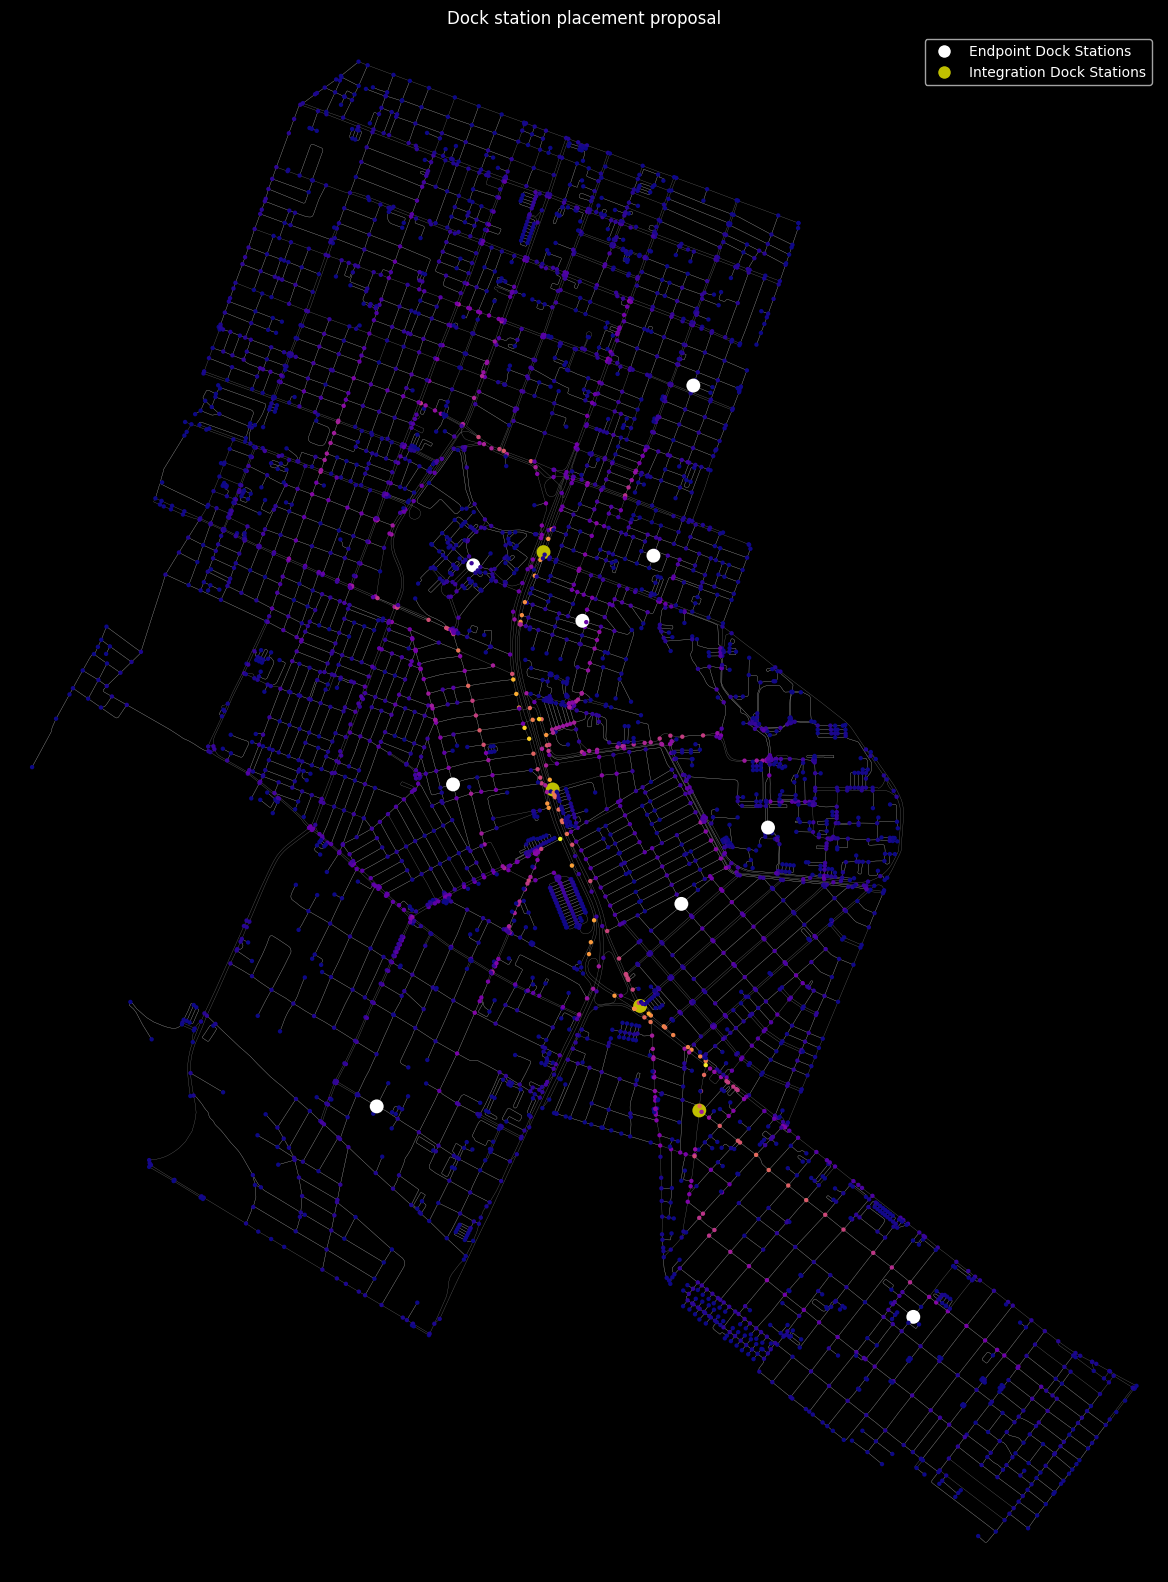

In [14]:
fig, ax = plt.subplots(figsize=(20, 20))
nc = ox.plot.get_node_colors_by_attr(S, 'bc', cmap="plasma")
ax.set_title("Dock station placement proposal")

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Endpoint Dock Stations', markersize=10, markerfacecolor='w'),
                   Line2D([0], [0], marker='o', color='k', label='Integration Dock Stations', markersize=10, markerfacecolor='y'),]
ax.legend(handles=legend_elements, loc='upper right')

ox.plot_graph(
    S,
    ax=ax,
    node_color= ['w' if node in center_nodes else 'y' if node in integration_stations else nc.get(node) for node in S.nodes],
    node_size=[100 if  (node in center_nodes or node in integration_stations) else 10 for node in S.nodes],
    edge_linewidth=0.2,
    edge_color="tab:gray",
)

plt.show()

The arrangement of these 9 endpoint stations not only can help improve the mobility of university students in and out the university campus but also helps people with their last mile daily commute as they are located in the heart of residential areas (with the exception of the one at the Administrative Center) and close to the structural mobility axis that have 4 integration stations to dock the bike and change mode of transportation for longer trips.